# Analysis on Bakery Data
- The dataset contains purchase (a receipt, 'ticket') info with timestamps, product name and unit price.
- The notebook shows,
    - Data sanitization,
    - Receipt segmentation by per-ticket value,
    - Plots on those with weekly-daily-hourly timeframes,
    - And product popularity to each revenue group.
- I suggest applicable promotions regarding to above.

# Methods

## Load Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import (
    zscore
)
from sklearn.preprocessing import KBinsDiscretizer
from mlxtend.frequent_patterns import (
    apriori,
    association_rules
)

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

_weekday_name_map={
    0:'Monday',
    1:'Tuesday',
    2:'Wedsday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}

dataset_path='/kaggle/input/french-bakery-daily-sales/Bakery sales.csv'
dataset_org=pd.read_csv(dataset_path).drop('Unnamed: 0',axis=1)

## Preprocessing: Sanitization
- Timestamps were parsed to per-unit columns, and string columns were cleaned with methods. The processed columns were concatenated with explicit type casting.

In [2]:
ticket=dataset_org.ticket_number.astype('u4').astype('str')

datetime=pd.to_datetime(
    dataset_org.loc[:,['date','time']].agg(' '.join,axis=1),
    format='%Y-%m-%d %H:%M'
)
date=pd.to_datetime(
    dataset_org.loc[:,'date'],
    format='%Y-%m-%d'
)
dateQuarter=date.dt.quarter.map(
    lambda q: f'Q{q}'
).astype('str')
dateMonth=date.dt.month
dateWeek=date.dt.isocalendar().week
dateDay=date.dt.weekday.map(
    lambda q: _weekday_name_map[q]
).astype('str')

time=pd.to_datetime(
  dataset_org.loc[:,'time'],
  format='%H:%M'
)
timeHour=time.dt.hour.astype('u4')
timeMinute=time.dt.minute.astype('u4')

article=dataset_org.loc[:,'article'].str.strip().str.lower().str.title()
qty=dataset_org.loc[:,'Quantity'].astype('i4')
price=dataset_org.loc[:,'unit_price'].str.replace(',','.').str.replace(' €','').astype('f4')
value=qty * price

dataset=pd.concat([
    ticket,
    datetime,
    date,
    dateQuarter,
    dateMonth,
    dateWeek,
    dateDay,
    time,
    timeHour,
    timeMinute,
    article,
    qty,
    price,
    value
],axis=1).set_axis([
    'ticket',
    'datetime',
    'date',
    'dateQuarter',
    'dateMonth',
    'dateWeek',
    'dateDay',
    'time',
    'timeHour',
    'timeMinute',
    'article',
    'qty',
    'price',
    'value'
],axis=1)

dataset.sample(3)

,ticket,datetime,date,dateQuarter,dateMonth,dateWeek,dateDay,time,timeHour,timeMinute,article,qty,price,value
85715,200168,2021-08-15 12:41:00,2021-08-15,Q3,8,32,Sunday,1900-01-01 12:41:00,12,41,Traditional Baguette,2,1.2,2.4
176225,254406,2022-06-02 12:10:00,2022-06-02,Q2,6,22,Thursday,1900-01-01 12:10:00,12,10,Cereal Baguette,1,1.3,1.3
159664,244424,2022-04-19 11:05:00,2022-04-19,Q2,4,16,Tuesday,1900-01-01 11:05:00,11,5,Banette,1,1.1,1.1


## Preprocessing: Product Names
- 'article' column contains product names. There's a rational way to get product categories (e.g. drinks, breads, pastries). <ins>[Refer to this notebook](https://www.kaggle.com/code/teawithlemon/analyzing-french-bakery-sales-part-i).</ins> I'm going to drop tickets with seasonal products (occurs 4>times only) and refunded products (quantity<0). 

In [3]:
article_nominal_name={
    r'Boule.*':'Boule',
    r'Tarte Fruits.*':'Tarte Fruits',
    r'Royal.*':'Royal'
}

dataset=dataset.replace(
    {'article':article_nominal_name},
    regex=True
)

In [4]:
article_seasonal_check=dataset.groupby('article').dateQuarter.nunique()
article_seasonal=article_seasonal_check[article_seasonal_check!=4].index.to_list()

ticket_seasonal=dataset.loc[dataset.article.isin(article_seasonal)].ticket.to_list()
ticket_seasonal_sieve=~dataset.ticket.isin(ticket_seasonal)

In [5]:
ticket_refunded=dataset.loc[dataset.qty<0].ticket.to_list()
row_refunded=dataset.loc[dataset.ticket.isin(ticket_refunded)]
row_refunded_check=(row_refunded.groupby(['ticket','article']).qty.sum()<0).value_counts()

ticket_refunded_sieve=~dataset.ticket.isin(ticket_refunded)

In [6]:
# dataset without seasonal articles and refunded tickets
dataset_sieved=dataset.loc[ticket_seasonal_sieve & ticket_refunded_sieve]
dataset_sieved.head(3)

,ticket,datetime,date,dateQuarter,dateMonth,dateWeek,dateDay,time,timeHour,timeMinute,article,qty,price,value
0,150040,2021-01-02 08:38:00,2021-01-02,Q1,1,53,Saturday,1900-01-01 08:38:00,8,38,Baguette,1,0.9,0.9
1,150040,2021-01-02 08:38:00,2021-01-02,Q1,1,53,Saturday,1900-01-01 08:38:00,8,38,Pain Au Chocolat,3,1.2,3.6
2,150041,2021-01-02 09:14:00,2021-01-02,Q1,1,53,Saturday,1900-01-01 09:14:00,9,14,Pain Au Chocolat,2,1.2,2.4


## Preprocessing: Binning by Average Revenue Per Ticket
- I generated 4 groups of tickets by per-ticket value.

In [7]:
ticket_value=dataset_sieved.loc[:,['ticket','value']].groupby('ticket',as_index=False).sum()
ticket_value.head(3)

,ticket,value
0,150040,4.50
1,150041,3.55
2,150042,6.00


In [8]:
discretizer=KBinsDiscretizer(n_bins=4,encode='ordinal',subsample=None)

ticket_value=ticket_value.assign(
    valueType=(
        discretizer.fit_transform(ticket_value[['value']]).astype('u4').astype('str')
    )
)

dataset_sieved_merged=dataset_sieved.merge(
    ticket_value.loc[:,['ticket','valueType']],
    on='ticket',
    how='left'
)

dataset_sieved_merged.head(3)

,ticket,datetime,date,dateQuarter,dateMonth,dateWeek,dateDay,time,timeHour,timeMinute,article,qty,price,value,valueType
0,150040,2021-01-02 08:38:00,2021-01-02,Q1,1,53,Saturday,1900-01-01 08:38:00,8,38,Baguette,1,0.9,0.9,2
1,150040,2021-01-02 08:38:00,2021-01-02,Q1,1,53,Saturday,1900-01-01 08:38:00,8,38,Pain Au Chocolat,3,1.2,3.6,2
2,150041,2021-01-02 09:14:00,2021-01-02,Q1,1,53,Saturday,1900-01-01 09:14:00,9,14,Pain Au Chocolat,2,1.2,2.4,2


## Preprocessing: Item Basket and Popularity
- I tried to get a basket analysis via mlxtend. Item popularity (sold count) by per-ticket revenue group is created.

In [9]:
ticket_basket=dataset_sieved_merged.pivot_table(
    values='qty',
    index='ticket',
    columns='article',
    aggfunc='sum',
    fill_value=0
)
ticket_basket=ticket_basket.where(ticket_basket==0, 1)

ticket_basket.head(3)

article,Baguette,Baguette Apero,Baguette Graine,Banette,Banettine,Boisson 33Cl,Boule,Brioche,Briochette,Brownies,...,Sucette,Tarte Fine,Tarte Fruits,Tartelette,The,Traditional Baguette,Traiteur,Tropezienne,Tropezienne Framboise,Vik Bread
ticket,,,,,,,,,,,,,,,,,,,,,
150040,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
ticket_basket_compressed=ticket_basket.iloc[:,:-1].merge(
    dataset_sieved_merged.loc[:,['ticket','valueType']].drop_duplicates(),
    how='left',
    on='ticket'
).drop('ticket',axis=1).groupby('valueType').mean()

ticket_expression_norm=pd.DataFrame(
    data=zscore(ticket_basket_compressed.to_numpy('f4')),
    index=ticket_basket_compressed.index,
    columns=ticket_basket_compressed.columns,
).T

ticket_expression_norm.head(3)

# 1.644 -0.081 -0.595 -0.967

valueType,0,1,2,3
Baguette,1.644060,-0.081309,-0.595145,-0.967605
Baguette Apero,-0.963132,-0.963132,0.582669,1.343596
Baguette Graine,-1.549249,-0.200358,0.995470,0.754137


In [11]:
def sellcount(q): return np.count_nonzero(q.to_numpy('i4'))

ticket_basket.agg(
    ['median','mean',sellcount]
).T.sort_values('sellcount', ascending=False).head(5).style.format('{:.2f}')

,median,mean,sellcount
article,,,
Traditional Baguette,0.00,0.50,65793.00
Coupe,0.00,0.14,18883.00
Baguette,0.00,0.11,14992.00
Banette,0.00,0.11,14730.00
Croissant,0.00,0.08,11106.00


In [12]:
frequent_item=apriori(
    ticket_basket.astype('bool'),
    min_support=5e-3,
    use_colnames=True
)

assoc_rules=association_rules(
    frequent_item,
    metric='leverage',
    num_itemsets=ticket_basket.shape[0],
    min_threshold=-1
).query(
    '(leverage <= 5e-3 * -1) | (leverage >= 5e-3)'
).drop_duplicates('leverage').sort_values('leverage',ascending=False)

assoc_rules.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
22,(Boule),(Coupe),0.052997,0.142779,0.043802,0.826509,5.788713,1.0,0.036236,4.941003,0.873545,0.288223,0.797612,0.566646
52,(Pain Au Chocolat),(Croissant),0.077299,0.083975,0.039598,0.512276,6.100312,1.0,0.033107,1.878163,0.906116,0.325441,0.467565,0.491912
28,(Coupe),(Campagne),0.142779,0.028755,0.022971,0.160885,5.594947,1.0,0.018865,1.157464,0.958058,0.154621,0.136042,0.479864


# Results

In [13]:
dataset_ticket_px=dataset_sieved_merged.groupby(
    ['ticket','datetime','dateQuarter','dateWeek','dateDay','timeHour','valueType'],
    as_index=False
)['value'].sum()

sns.set(rc={
  'axes.xmargin': .01,
  'axes.ymargin': .005,
  'axes.facecolor': '#ffffff',
  'axes.edgecolor': '#000000',
  'xtick.bottom': True,
  'ytick.left': True,
  'xtick.color': '#000000',
  'ytick.color': '#000000',
})

## Weekly Plots

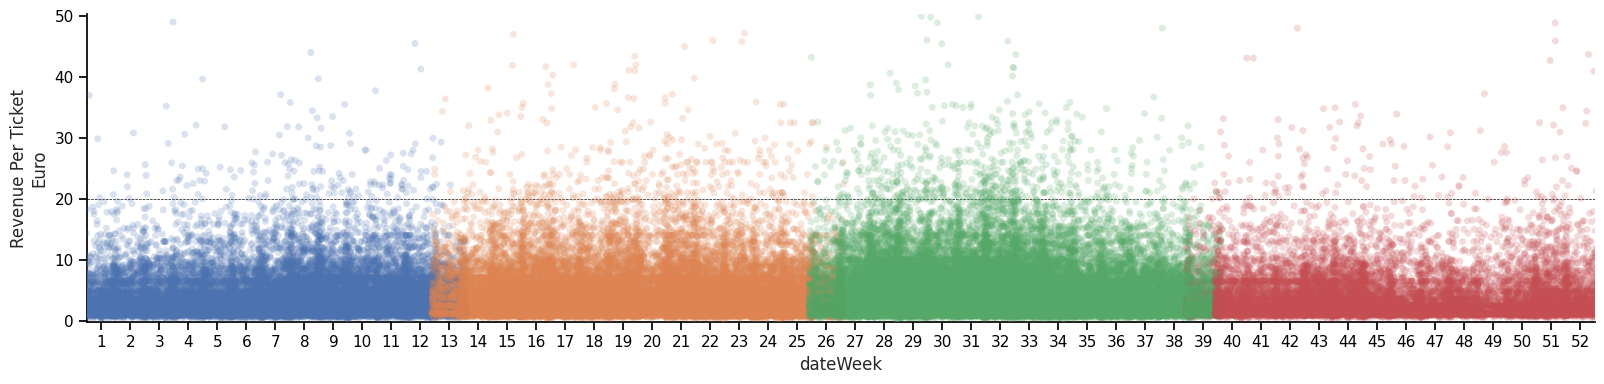

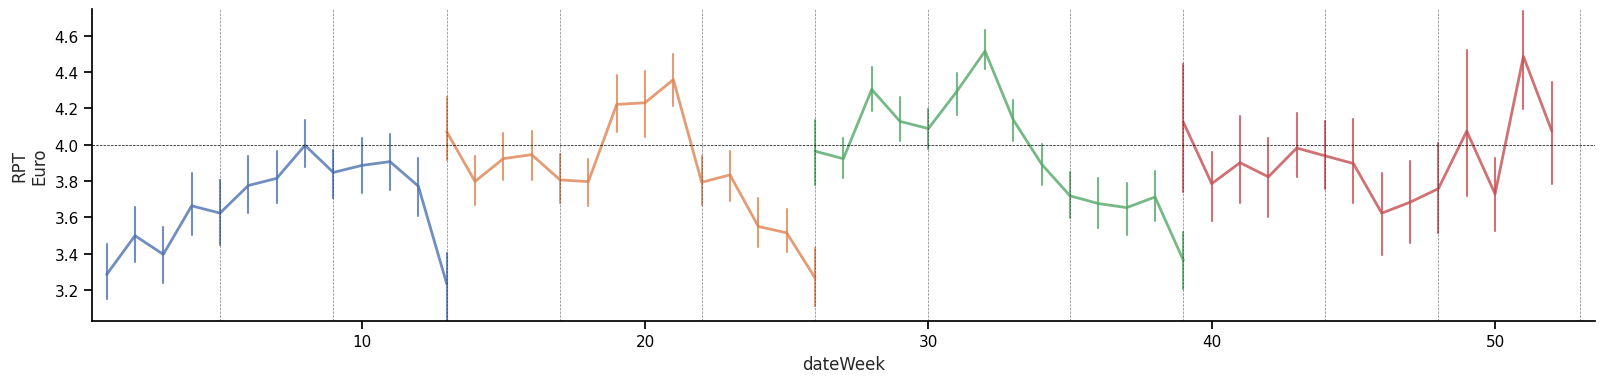

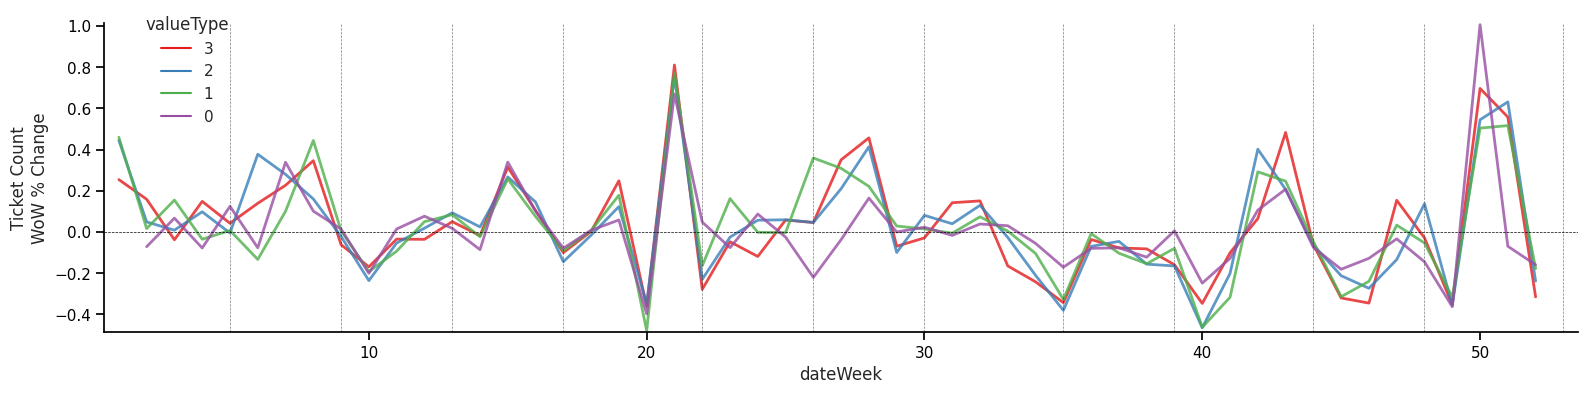

In [14]:
graph=sns.catplot(
    kind='strip',
    
    data=dataset_ticket_px.query(
      "(value <= 50) & ~(dateQuarter == 'Q1' & dateWeek > 51)"
    ),
    x='dateWeek',
    y='value',

    hue='dateQuarter',
    hue_order=['Q1','Q2','Q3','Q4'],

    dodge=False,
    
    jitter=.6,
    alpha=.2,
    legend=None,
    
    height=4,
    aspect=4
)

graph.refline(y=20, color='#000000', linewidth=.5, linestyle='dashed')
graph.set(ylabel='Revenue Per Ticket\nEuro')

graph=sns.relplot(
    kind='line',
    
    data=dataset_ticket_px.query(
      "(value <= 50) & ~(dateQuarter == 'Q1' & dateWeek > 51)"
    ),
    x='dateWeek',
    y='value',
    
    hue='dateQuarter',
    hue_order=['Q1','Q2','Q3','Q4'],

    linewidth=2,
    err_style='bars',
    n_boot=300,

    alpha=.8,
    legend=None,
    
    height=4,
    aspect=4
)

for m in dataset_sieved_merged.loc[:,['dateWeek','dateMonth']].drop_duplicates(subset='dateMonth').dateWeek:
  graph.refline(x=m, color='#000000', linewidth=.5, linestyle='dashed', alpha=.5)
graph.refline(y=4, color='#000000', linewidth=.5, linestyle='dashed')
graph.set(ylabel='RPT\nEuro')

graph=sns.relplot(
    kind='line',
    
    data=dataset_ticket_px.query(
      "(value <= 50) & ~(dateQuarter == 'Q1' & dateWeek > 51)"
    ).groupby(['valueType','dateWeek'])['ticket'].count().pct_change().dropna().reset_index(),
    x='dateWeek',
    y='ticket',
    
    hue='valueType',
    hue_order=list('3210'),
    palette='Set1',

    linewidth=2,

    alpha=.8,
    legend='full',
    
    height=4,
    aspect=4
)


for m in dataset_sieved_merged.loc[:,['dateWeek','dateMonth']].drop_duplicates(subset='dateMonth').dateWeek:
  graph.refline(x=m, color='#000000', linewidth=.5, linestyle='dashed', alpha=.5)
graph.refline(y=0, color='#000000', linewidth=.5, linestyle='dashed')
graph.set(ylabel='Ticket Count\nWoW % Change')
sns.move_legend(graph, 'upper left', bbox_to_anchor=[.07,1])

- The top two plots show frequency and average revenue per ticket to week of year. From Q2 to Q3 shows more revenue per ticket than Q1 and Q4. The difference is probably because of season.
- The bottom two plots indicates 3 peaks in Q2, Q3, and Q4. The peak in Q2 and Q4 is related to holidays. The time of both ARPT peak and purchase volatility shows the client actually spent more money in this time. This shows importance of ARPT for retail stores. Q3 peak is related to season. While smaller change ticket count, Q3 shows higher ARPT than others as more peoples go outside.
- There's a remarkable dip for all ARPT groups in March, and group 0 (lowest ARPT) in June. This is probably related to students, or school. 

## Daily and Hourly Plots

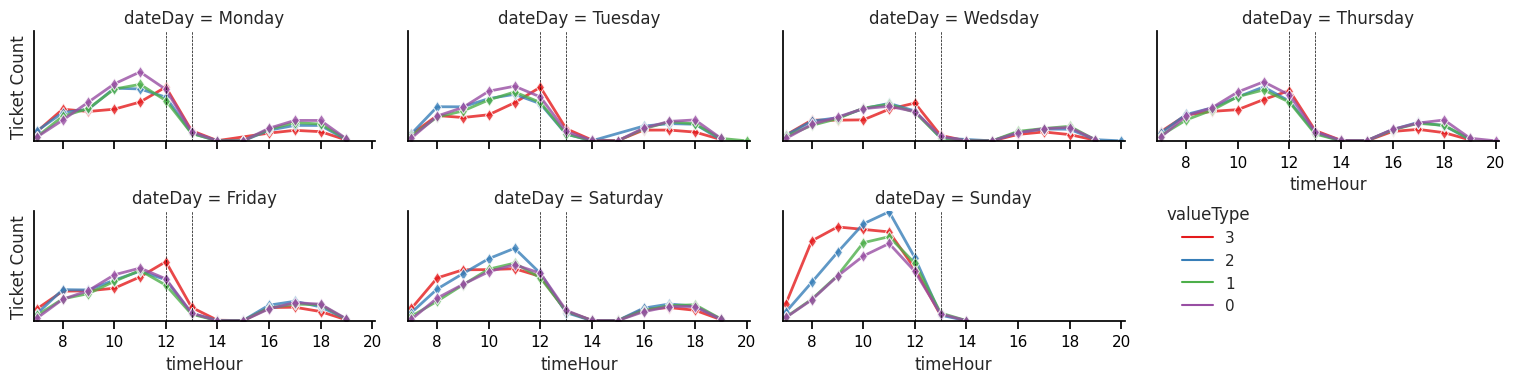

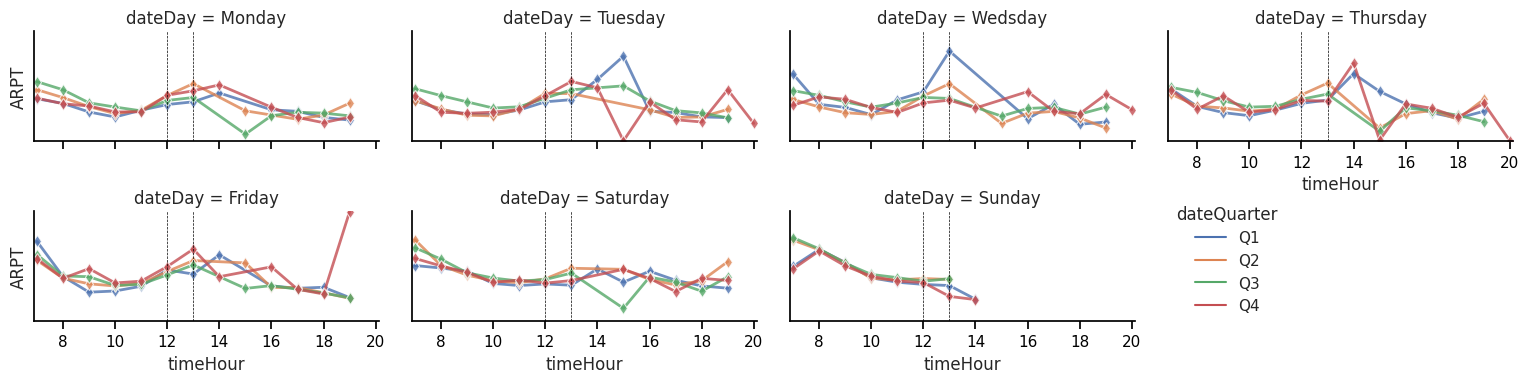

In [15]:
graph=sns.relplot(
    kind='line',
    
    data=dataset_ticket_px.groupby(
        ['dateDay','timeHour','valueType'],
        as_index=False
    )['ticket'].count(),
    x='timeHour',
    y='ticket',

    col='dateDay',
    col_order=_weekday_name_map.values(),
    col_wrap=4,
    
    hue='valueType',
    hue_order=list('3210'),
    palette='Set1',

    marker='d',
    
    linewidth=2,
    alpha=.8,
    legend='full',
    
    height=2,
    aspect=2
)

graph.refline(x=12, color='#000000', linewidth=.5, linestyle='dashed')
graph.refline(x=13, color='#000000', linewidth=.5, linestyle='dashed')
graph.set(ylabel='Ticket Count',yticks=[])
sns.move_legend(graph, 'upper left', bbox_to_anchor=[.715,.5])

graph=sns.relplot(
    kind='line',
    
    data=dataset_ticket_px.query('value <= 50').groupby(
        ['dateQuarter','dateDay','timeHour','ticket'],
        as_index=False
    )['value'].mean(),
    x='timeHour',
    y='value',

    col='dateDay',
    col_order=_weekday_name_map.values(),
    col_wrap=4,
    
    hue='dateQuarter',
    hue_order=['Q1','Q2','Q3','Q4'],

    marker='d',
    
    errorbar=None,

    linewidth=2,
    alpha=.8,
    legend='full',
    
    height=2,
    aspect=2
)

graph.refline(x=12, color='#000000', linewidth=.5, linestyle='dashed')
graph.refline(x=13, color='#000000', linewidth=.5, linestyle='dashed')
graph.set(ylabel='ARPT',yticks=[])
sns.move_legend(graph, 'upper left', bbox_to_anchor=[.705,.5])

- Daily purchases shows a constant peak in the morning among ARPT groups. Unlike the bakeries in Korea, French peoples tend to buy breads from the morning to lunch for a meal. There's clear difference of hourly ARPT by day to quarters.

## Article Preferences by Average Revenue Per Ticket Group

In [16]:
ticket_expression_norm.style.format('{:.1f}').bar(subset=ticket_expression_norm.columns.to_list(),color='#d68f8f')

valueType,0,1,2,3
Baguette,1.6,-0.1,-0.6,-1.0
Baguette Apero,-1.0,-1.0,0.6,1.3
Baguette Graine,-1.5,-0.2,1.0,0.8
Banette,1.6,0.1,-0.8,-0.9
Banettine,1.1,0.9,-1.0,-1.0
Boisson 33Cl,-1.0,-0.6,-0.1,1.6
Boule,-1.5,1.1,0.6,-0.2
Brioche,-0.6,-0.6,-0.6,1.7
Briochette,-1.0,-0.7,0.0,1.6
Brownies,-0.9,-0.9,0.2,1.6


- The table shows major difference between ARPT groups. While the lowest revenue group does not include sweats and visit the store for a meal (pain, banettes, baguettes), the highest has preferences to deserts (tarts, sucette, financier). We can see this tendency get clear for transitonal ARPT groups.

In [17]:
item_behavior_flow=pd.concat([
    assoc_rules.loc[:,['antecedents','consequents']].map(
        lambda q: ', '.join([w for w in q])
    ).agg(
        lambda q: ' -> '.join(q), axis=1
    ),
    assoc_rules.loc[:,'leverage']
],axis=1).set_axis(
    ['Item Behavior Flow','Coefficient']
,axis=1).set_index(
    'Item Behavior Flow',
    drop=True
)

item_behavior_flow.style.format('{:.3f}').bar(subset=['Coefficient'],color='#d68f8f')

,Coefficient
Item Behavior Flow,
Boule -> Coupe,0.036
Pain Au Chocolat -> Croissant,0.033
Coupe -> Campagne,0.019
Special Bread -> Coupe,0.017
"Pain Au Chocolat, Traditional Baguette -> Croissant",0.014
Complet -> Coupe,0.014
"Traditional Baguette, Croissant -> Pain Au Chocolat",0.014
Coupe -> Vik Bread,0.013
Coupe -> Moisson,0.013


- The above table provides brief relevance between frequently associated item sets. The client would not buy another hard bread for a meal. Further categorization upon the context of the store might be helpful to getting item relevance.

# Suggestions
- Based on the figures and tables in the above,
    - The store would have a revisit promotions like coupon for sweats. The coupon have to be available from mid of Q3, and usuable for the next year's Q1.
    - Promotions between sweat articles might be useful for the highest payers based on preferences table.
    - There's hourly difference between the lowest (clients for meals) and the highest (perferring sweats) group. The store would have preparation on site for sweats client shortly after the meal clients.
    - Pain for meal could be couped if possible to cope with workload in the morning.
    - There's unlikely a feasible options to convert the lowest group to higher payer as they have uniform reason to visit the store.